# 3 layer LSTM Encoder Decoder, dropout. 120 day input, 10 day forecast

In [1]:
import numpy as np
import pandas as pd
import json
import os
import math
import datetime as dt
import matplotlib.pyplot as plt
from numpy import newaxis
from keras.optimizers import Adam
from keras.layers import Dense, Activation, Dropout, LSTM, CuDNNLSTM, BatchNormalization, RepeatVector, TimeDistributed
from keras.models import Sequential, load_model
from sklearn.metrics import mean_squared_error, mean_absolute_error
from keras import regularizers

import utils
import model_funcs

%load_ext autoreload
%autoreload 2

plt.rcParams['figure.figsize'] = [16, 9]
%matplotlib inline

Using TensorFlow backend.


In [2]:
save_dir = 'models/lstm4.64'
df = pd.read_csv('data_25_normalized.csv', index_col='Date')
num_skew_end = 15
data = df.values[:-num_skew_end]

In [3]:
num_input = 120
num_out = 10
train_X, train_y, dev_X, dev_y, test_X, test_y, train_y_acc, dev_y_acc, test_y_acc = utils.prepare_data(data, num_input, num_preds=num_out)

train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
dev_y = dev_y.reshape((dev_y.shape[0], dev_y.shape[1], 1))
test_y = test_y.reshape((test_y.shape[0], test_y.shape[1], 1))
train_y_acc = train_y_acc.reshape((train_y.shape[0], train_y.shape[1], 1))
dev_y_acc = dev_y_acc.reshape((dev_y.shape[0], dev_y.shape[1], 1))
test_y_acc = test_y_acc.reshape((test_y.shape[0], test_y.shape[1], 1))

print("train_X shape", train_X.shape)
print("train_y shape", train_y.shape)
print("dev_X shape", dev_X.shape)
print("dev_y shape", dev_y.shape)
print("test_X shape", test_X.shape)
print("test_y shape", test_y.shape)
print("train_y_acc shape", train_y_acc.shape)
print("dev_y_acc shape", dev_y_acc.shape)
print("test_y_acc shape", test_y_acc.shape)


train_X shape (585, 120, 25)
train_y shape (585, 10, 1)
dev_X shape (69, 120, 25)
dev_y shape (69, 10, 1)
test_X shape (35, 120, 25)
test_y shape (35, 10, 1)
train_y_acc shape (585, 10, 1)
dev_y_acc shape (69, 10, 1)
test_y_acc shape (35, 10, 1)


In [4]:
if not os.path.exists(save_dir): os.makedirs(save_dir)

input_shape = train_X.shape[1:]
lr = 0.0005
decay = 1e-6
dropout_rate = 0.4
epochs = 1000
batch_size = 32

model = Sequential()
model.add(CuDNNLSTM(200, input_shape=input_shape))
model.add(Dropout(dropout_rate))
model.add(RepeatVector(num_out))
model.add(CuDNNLSTM(200, return_sequences=True))
model.add(Dropout(dropout_rate))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(1)))

opt = Adam(lr=lr, decay=decay)
model.compile(loss="mae", optimizer=opt)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 200)               181600    
_________________________________________________________________
dropout_1 (Dropout)          (None, 200)               0         
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 10, 200)           0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 10, 200)           321600    
_________________________________________________________________
dropout_2 (Dropout)          (None, 10, 200)           0         
_________________________________________________________________
time_distributed_1 (T

In [5]:
history = model_funcs.train(
    model,
    train_X,
    train_y,
    (dev_X, dev_y),
    epochs = epochs,
    batch_size = batch_size,
    save_dir = save_dir
)

[Model] Training Started
[Model] 1000 epochs, 32 batch size
Instructions for updating:
Use tf.cast instead.
Train on 585 samples, validate on 69 samples
Epoch 1/1000
585/585 [==============================] - 2s 4ms/step - loss: 0.1192 - val_loss: 0.0954
Epoch 2/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0701 - val_loss: 0.0733
Epoch 3/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0571 - val_loss: 0.0642
Epoch 4/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0508 - val_loss: 0.0476
Epoch 5/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0478 - val_loss: 0.0489
Epoch 6/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0437 - val_loss: 0.0626
Epoch 7/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0416 - val_loss: 0.0521
Epoch 8/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0395 - val_loss: 0.0485
Epoch 9/1000
585/585 [=========

Epoch 77/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0211 - val_loss: 0.0243
Epoch 78/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0204 - val_loss: 0.0210
Epoch 79/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0228 - val_loss: 0.0249
Epoch 80/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0211 - val_loss: 0.0200
Epoch 81/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0211 - val_loss: 0.0210
Epoch 82/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0203 - val_loss: 0.0206
Epoch 83/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0200 - val_loss: 0.0189
Epoch 84/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0205 - val_loss: 0.0251
Epoch 85/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0194 - val_loss: 0.0204
Epoch 86/1000
585/585 [==============================] - 1s 1ms/step - lo

Epoch 156/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0160 - val_loss: 0.0195
Epoch 157/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0167 - val_loss: 0.0181
Epoch 158/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0167 - val_loss: 0.0186
Epoch 159/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0157 - val_loss: 0.0158
Epoch 160/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0174 - val_loss: 0.0147
Epoch 161/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0157 - val_loss: 0.0181
Epoch 162/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0162 - val_loss: 0.0212
Epoch 163/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0163 - val_loss: 0.0160
Epoch 164/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0167 - val_loss: 0.0164
Epoch 165/1000
585/585 [==============================] - 1s 1ms

Epoch 235/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0146 - val_loss: 0.0148
Epoch 236/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0143 - val_loss: 0.0161
Epoch 237/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0141 - val_loss: 0.0173
Epoch 238/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0147 - val_loss: 0.0180
Epoch 239/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0149 - val_loss: 0.0192
Epoch 240/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0142 - val_loss: 0.0151
Epoch 241/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0142 - val_loss: 0.0168
Epoch 242/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0149 - val_loss: 0.0143
Epoch 243/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0150 - val_loss: 0.0163
Epoch 244/1000
585/585 [==============================] - 1s 1ms

Epoch 314/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0135 - val_loss: 0.0179
Epoch 315/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0132 - val_loss: 0.0155
Epoch 316/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0140 - val_loss: 0.0151
Epoch 317/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0136 - val_loss: 0.0160
Epoch 318/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0136 - val_loss: 0.0169
Epoch 319/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0139 - val_loss: 0.0222
Epoch 320/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0137 - val_loss: 0.0155
Epoch 321/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0130 - val_loss: 0.0136
Epoch 322/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0135 - val_loss: 0.0152
Epoch 323/1000
585/585 [==============================] - 1s 1ms

Epoch 393/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0124 - val_loss: 0.0134
Epoch 394/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0126 - val_loss: 0.0126
Epoch 395/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0128 - val_loss: 0.0145
Epoch 396/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0125 - val_loss: 0.0165
Epoch 397/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0123 - val_loss: 0.0177
Epoch 398/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0126 - val_loss: 0.0135
Epoch 399/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0126 - val_loss: 0.0139
Epoch 400/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0126 - val_loss: 0.0156
Epoch 401/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0124 - val_loss: 0.0161
Epoch 402/1000
585/585 [==============================] - 1s 1ms

Epoch 472/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0121 - val_loss: 0.0161
Epoch 473/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0125 - val_loss: 0.0169
Epoch 474/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0131 - val_loss: 0.0126
Epoch 475/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0127 - val_loss: 0.0163
Epoch 476/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0127 - val_loss: 0.0122
Epoch 477/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0126 - val_loss: 0.0140
Epoch 478/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0121 - val_loss: 0.0161
Epoch 479/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0121 - val_loss: 0.0145
Epoch 480/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0119 - val_loss: 0.0122
Epoch 481/1000
585/585 [==============================] - 1s 1ms

Epoch 551/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0117 - val_loss: 0.0135
Epoch 552/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0118 - val_loss: 0.0170
Epoch 553/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0125 - val_loss: 0.0143
Epoch 554/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0125 - val_loss: 0.0155
Epoch 555/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0120 - val_loss: 0.0176
Epoch 556/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0130 - val_loss: 0.0143
Epoch 557/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0122 - val_loss: 0.0138
Epoch 558/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0122 - val_loss: 0.0119
Epoch 559/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0121 - val_loss: 0.0152
Epoch 560/1000
585/585 [==============================] - 1s 1ms

Epoch 630/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0131 - val_loss: 0.0163
Epoch 631/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0118 - val_loss: 0.0128
Epoch 632/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0114 - val_loss: 0.0194
Epoch 633/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0120 - val_loss: 0.0134
Epoch 634/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0118 - val_loss: 0.0138
Epoch 635/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0113 - val_loss: 0.0137
Epoch 636/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0108 - val_loss: 0.0141
Epoch 637/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0110 - val_loss: 0.0143
Epoch 638/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0113 - val_loss: 0.0157
Epoch 639/1000
585/585 [==============================] - 1s 1ms

Epoch 709/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0113 - val_loss: 0.0121
Epoch 710/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0115 - val_loss: 0.0122
Epoch 711/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0109 - val_loss: 0.0152
Epoch 712/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0110 - val_loss: 0.0165
Epoch 713/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0108 - val_loss: 0.0156
Epoch 714/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0114 - val_loss: 0.0173
Epoch 715/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0105 - val_loss: 0.0153
Epoch 716/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0110 - val_loss: 0.0157
Epoch 717/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0109 - val_loss: 0.0145
Epoch 718/1000
585/585 [==============================] - 1s 1ms

Epoch 788/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0108 - val_loss: 0.0163
Epoch 789/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0106 - val_loss: 0.0118
Epoch 790/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0105 - val_loss: 0.0127
Epoch 791/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0107 - val_loss: 0.0131
Epoch 792/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0104 - val_loss: 0.0151
Epoch 793/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0105 - val_loss: 0.0171
Epoch 794/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0110 - val_loss: 0.0120
Epoch 795/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0108 - val_loss: 0.0174
Epoch 796/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0107 - val_loss: 0.0153
Epoch 797/1000
585/585 [==============================] - 1s 1ms

Epoch 867/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0102 - val_loss: 0.0161
Epoch 868/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0102 - val_loss: 0.0172
Epoch 869/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0099 - val_loss: 0.0150
Epoch 870/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0097 - val_loss: 0.0120
Epoch 871/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0102 - val_loss: 0.0164
Epoch 872/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0100 - val_loss: 0.0157
Epoch 873/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0098 - val_loss: 0.0170
Epoch 874/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0099 - val_loss: 0.0145
Epoch 875/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0099 - val_loss: 0.0146
Epoch 876/1000
585/585 [==============================] - 1s 1ms

Epoch 946/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0099 - val_loss: 0.0150
Epoch 947/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0103 - val_loss: 0.0149
Epoch 948/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0100 - val_loss: 0.0138
Epoch 949/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0101 - val_loss: 0.0135
Epoch 950/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0100 - val_loss: 0.0116
Epoch 951/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0097 - val_loss: 0.0140
Epoch 952/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0097 - val_loss: 0.0143
Epoch 953/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0096 - val_loss: 0.0139
Epoch 954/1000
585/585 [==============================] - 1s 1ms/step - loss: 0.0098 - val_loss: 0.0161
Epoch 955/1000
585/585 [==============================] - 1s 1ms

In [6]:
preds_train = model.predict(train_X).squeeze()
preds_dev = model.predict(dev_X).squeeze()
preds_test = model.predict(test_X).squeeze()
print("MSE Train:", mean_squared_error(preds_train.reshape(-1,1), train_y.reshape(-1,1)))
print("MSE Dev:", mean_squared_error(preds_dev.reshape(-1,1), dev_y.reshape(-1,1)))
print("MSE Test:", mean_squared_error(preds_test.reshape(-1,1), test_y.reshape(-1,1)))

print("MAE Train:", mean_absolute_error(preds_train.reshape(-1,1), train_y.reshape(-1,1)))
print("MAE Dev:", mean_absolute_error(preds_dev.reshape(-1,1), dev_y.reshape(-1,1)))
print("MAE Test:", mean_absolute_error(preds_test.reshape(-1,1), test_y.reshape(-1,1)))

MSE Train: 0.0005104200025648477
MSE Dev: 0.0010680424876165747
MSE Test: 0.0005797086388035064
MAE Train: 0.011075846765859806
MAE Dev: 0.015635627233861277
MAE Test: 0.018552075627515905


In [7]:
import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

l = go.Scatter(y=history.history['loss'], name='train')
v = go.Scatter(y=history.history['val_loss'], name='dev')

data = [v,l]
py.iplot(data, filename='line-mode')

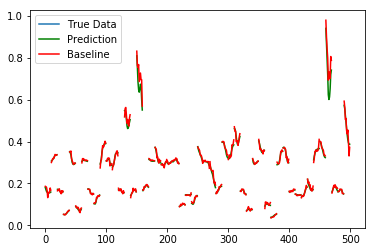

In [8]:
predicted_train = model.predict(train_X).squeeze()
predicted_train = predicted_train[::num_out]
true_train = train_y[::num_out].squeeze()
utils.plot_results_multiple(predicted_train.tolist()[:50], [], num_out, baseline_data=true_train.tolist()[:50])

# predicted_train = model.predict(train_X).squeeze()
# predicted_train = predicted_train[:, 0].reshape(-1,1)
# true_train = train_y[:, 0].reshape(-1,1)
# utils.plot_results(predicted_train[:50], true_train[:50])

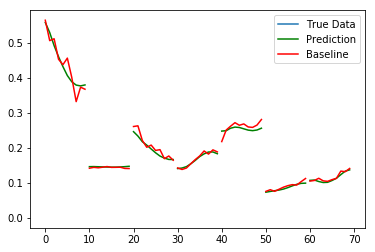

VAR MAE Dev: 0.005448766939753039
LSTM MAE Dev: 0.0001568886904595327
VAR MSE Dev: 0.005448766939753039
LSTM MSE Dev: 0.0001568886904595327


In [9]:
predicted_dev = model.predict(dev_X).squeeze()
predicted_dev = predicted_dev[::num_out]
true_dev = dev_y[::num_out].squeeze()
utils.plot_results_multiple(predicted_dev.tolist(), [0], num_out, baseline_data=true_dev.tolist())

true_dev = true_dev.reshape(-1,1)

var_preds_dev = utils.var_predict(dev_X[:, :, 0:5], num_out)
var_preds_dev = var_preds_dev[::num_out]

print("VAR MAE Dev:", mean_squared_error(var_preds_dev.reshape(-1,1), true_dev))
print("LSTM MAE Dev:", mean_squared_error(predicted_dev.reshape(-1,1), true_dev))

print("VAR MSE Dev:", mean_squared_error(var_preds_dev.reshape(-1,1), true_dev))
print("LSTM MSE Dev:", mean_squared_error(predicted_dev.reshape(-1,1), true_dev))

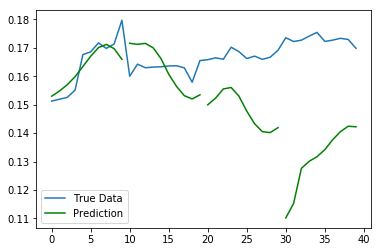

In [10]:
predicted_test = model.predict(test_X).squeeze()
predicted_test = predicted_test[::num_out]
true_test = test_y[::num_out].reshape(-1,1)
utils.plot_results_multiple(predicted_test.tolist(), true_test, num_out)

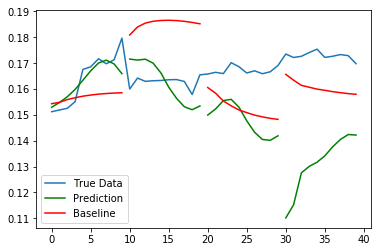

VAR MAE Test: 0.014679061944746335
LSTM MAE Test: 0.01803959258427071
VAR MSE Test: 0.0002570678369552715
LSTM MSE Test: 0.0005878125538330049


In [11]:
var_preds = utils.var_predict(test_X[:, :, 0:5], num_out)
var_preds = var_preds[::num_out]
    
utils.plot_results_multiple(predicted_test.tolist(), true_test, num_out, baseline_data=var_preds.tolist())

print("VAR MAE Test:", mean_absolute_error(var_preds.reshape(-1,1), true_test))
print("LSTM MAE Test:", mean_absolute_error(predicted_test.reshape(-1,1), true_test))

print("VAR MSE Test:", mean_squared_error(var_preds.reshape(-1,1), true_test))
print("LSTM MSE Test:", mean_squared_error(predicted_test.reshape(-1,1), true_test))

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/scipy/signal/signaltools.py:1344: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/statsmodels/base/model.py:508: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



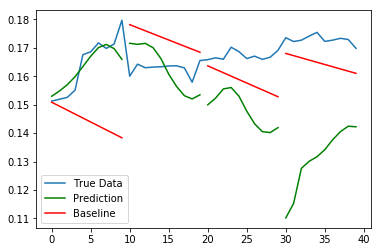

ARIMA MAE Test: 0.011817364924727753
LSTM MAE Test: 0.01803959258427071
ARIMA MSE Test: 0.00021404134489758325
LSTM MSE Test: 0.0005878125538330049


In [12]:
arima_preds = utils.arima_predict(test_X[:, :, 0], num_out)
arima_preds = arima_preds[::num_out]
    
utils.plot_results_multiple(predicted_test.tolist(), true_test, num_out, baseline_data=arima_preds.tolist())

print("ARIMA MAE Test:", mean_absolute_error(arima_preds.reshape(-1,1), true_test))
print("LSTM MAE Test:", mean_absolute_error(predicted_test.reshape(-1,1), true_test))

print("ARIMA MSE Test:", mean_squared_error(arima_preds.reshape(-1,1), true_test))
print("LSTM MSE Test:", mean_squared_error(predicted_test.reshape(-1,1), true_test))

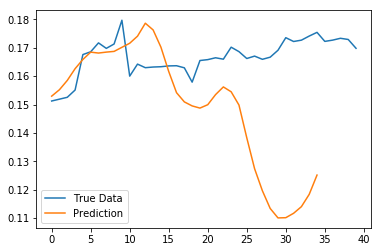

In [13]:
predicted_test_single = model.predict(test_X).squeeze()
predicted_test_single = predicted_test_single[:, 0]
utils.plot_results(predicted_test_single, true_test)